In [1]:
import re
from pyspark.ml import Pipeline
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType, StringType

from bigdl.nn.criterion import CrossEntropyCriterion
from zoo.common.nncontext import init_nncontext
from zoo.feature.image import RowToImageFeature, ImageResize, ImageCenterCrop, ImageChannelNormalize, ImageMatToTensor, ImageFeatureToTensor

from zoo.pipeline.api.keras.layers import Dense, Input, Flatten
from zoo.pipeline.api.keras.models import Model
from zoo.pipeline.api.net import Net
from zoo.pipeline.nnframes import NNImageReader, ChainedPreprocessing, NNClassifier

In [2]:
import matplotlib.pyplot as plt

In [3]:
sc = init_nncontext("ImageTransferLearningExample")

In [4]:
sc

<SparkContext master=local[4] appName=PySparkShell>

Load the pretrained model:

In [5]:
!wget 'https://s3-ap-southeast-1.amazonaws.com/bigdl-models/imageclassification/imagenet/bigdl_inception-v1_imagenet_0.4.0.model'

--2018-10-27 05:44:33--  https://s3-ap-southeast-1.amazonaws.com/bigdl-models/imageclassification/imagenet/bigdl_inception-v1_imagenet_0.4.0.model
Resolving s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)... 52.219.36.125
Connecting to s3-ap-southeast-1.amazonaws.com (s3-ap-southeast-1.amazonaws.com)|52.219.36.125|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28072260 (27M) [binary/octet-stream]
Saving to: ‘bigdl_inception-v1_imagenet_0.4.0.model’

bigdl_inception-v1_ 100%[===================>]  26.77M  6.76MB/s    in 7.8s    

2018-10-27 05:44:41 (3.44 MB/s) - ‘bigdl_inception-v1_imagenet_0.4.0.model’ saved [28072260/28072260]



In [6]:
!wget 'https://s3.amazonaws.com/elephantscale-public/bigdl/cat-dog.zip'

--2018-10-27 05:44:41--  https://s3.amazonaws.com/elephantscale-public/bigdl/cat-dog.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.81.3
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.81.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55019241 (52M) [application/zip]
Saving to: ‘cat-dog.zip’

cat-dog.zip         100%[===================>]  52.47M  23.7MB/s    in 2.2s    

2018-10-27 05:44:44 (23.7 MB/s) - ‘cat-dog.zip’ saved [55019241/55019241]



In [7]:
!unzip -o cat-dog.zip

Archive:  cat-dog.zip
   creating: cat-dog/
   creating: cat-dog/data/
   creating: cat-dog/data/validation/
   creating: cat-dog/data/validation/dogs/
  inflating: cat-dog/data/validation/dogs/dog.1303.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1356.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1211.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1314.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1205.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1390.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1220.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1399.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1379.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1275.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1186.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1193.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1345.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1187.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1235

  inflating: cat-dog/data/validation/dogs/dog.1248.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1183.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1173.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1191.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1203.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1296.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1490.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1149.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1335.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1255.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1410.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1138.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1346.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1145.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1261.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1105.jpg  
  inflating: cat-dog/data/validation/dogs/dog.1172.jpg  
  inflating: cat-dog/data/valid

  inflating: cat-dog/data/validation/cats/cat.1241.jpg  
  inflating: cat-dog/data/validation/cats/cat.1151.jpg  
  inflating: cat-dog/data/validation/cats/cat.1275.jpg  
  inflating: cat-dog/data/validation/cats/cat.1382.jpg  
  inflating: cat-dog/data/validation/cats/cat.1135.jpg  
  inflating: cat-dog/data/validation/cats/cat.1287.jpg  
  inflating: cat-dog/data/validation/cats/cat.1225.jpg  
  inflating: cat-dog/data/validation/cats/cat.1141.jpg  
  inflating: cat-dog/data/validation/cats/cat.1350.jpg  
  inflating: cat-dog/data/validation/cats/cat.1341.jpg  
  inflating: cat-dog/data/validation/cats/cat.1389.jpg  
  inflating: cat-dog/data/validation/cats/cat.1119.jpg  
  inflating: cat-dog/data/validation/cats/cat.1358.jpg  
  inflating: cat-dog/data/validation/cats/cat.1128.jpg  
  inflating: cat-dog/data/validation/cats/cat.1298.jpg  
  inflating: cat-dog/data/validation/cats/cat.1291.jpg  
  inflating: cat-dog/data/validation/cats/cat.1238.jpg  
  inflating: cat-dog/data/valid

  inflating: cat-dog/data/validation/cats/cat.1176.jpg  
  inflating: cat-dog/data/validation/cats/cat.1377.jpg  
  inflating: cat-dog/data/validation/cats/cat.1262.jpg  
  inflating: cat-dog/data/validation/cats/cat.1123.jpg  
  inflating: cat-dog/data/validation/cats/cat.1266.jpg  
  inflating: cat-dog/data/validation/cats/cat.1363.jpg  
  inflating: cat-dog/data/validation/cats/cat.1172.jpg  
  inflating: cat-dog/data/validation/cats/cat.1105.jpg  
  inflating: cat-dog/data/validation/cats/cat.1185.jpg  
  inflating: cat-dog/data/validation/cats/cat.1278.jpg  
  inflating: cat-dog/data/validation/cats/cat.1142.jpg  
  inflating: cat-dog/data/validation/cats/cat.1167.jpg  
  inflating: cat-dog/data/validation/cats/cat.1312.jpg  
  inflating: cat-dog/data/validation/cats/cat.1232.jpg  
  inflating: cat-dog/data/validation/cats/cat.1260.jpg  
  inflating: cat-dog/data/validation/cats/cat.1189.jpg  
  inflating: cat-dog/data/validation/cats/cat.1250.jpg  
  inflating: cat-dog/data/valid

  inflating: cat-dog/data/train/dogs/dog.474.jpg  
  inflating: cat-dog/data/train/dogs/dog.800.jpg  
  inflating: cat-dog/data/train/dogs/dog.805.jpg  
  inflating: cat-dog/data/train/dogs/dog.812.jpg  
  inflating: cat-dog/data/train/dogs/dog.469.jpg  
  inflating: cat-dog/data/train/dogs/dog.465.jpg  
  inflating: cat-dog/data/train/dogs/dog.966.jpg  
  inflating: cat-dog/data/train/dogs/dog.678.jpg  
  inflating: cat-dog/data/train/dogs/dog.490.jpg  
  inflating: cat-dog/data/train/dogs/dog.272.jpg  
  inflating: cat-dog/data/train/dogs/dog.920.jpg  
  inflating: cat-dog/data/train/dogs/dog.194.jpg  
  inflating: cat-dog/data/train/dogs/dog.635.jpg  
  inflating: cat-dog/data/train/dogs/dog.165.jpg  
  inflating: cat-dog/data/train/dogs/dog.664.jpg  
  inflating: cat-dog/data/train/dogs/dog.848.jpg  
  inflating: cat-dog/data/train/dogs/dog.689.jpg  
  inflating: cat-dog/data/train/dogs/dog.585.jpg  
  inflating: cat-dog/data/train/dogs/dog.479.jpg  
  inflating: cat-dog/data/train

  inflating: cat-dog/data/train/dogs/dog.460.jpg  
  inflating: cat-dog/data/train/dogs/dog.394.jpg  
  inflating: cat-dog/data/train/dogs/dog.298.jpg  
  inflating: cat-dog/data/train/dogs/dog.761.jpg  
  inflating: cat-dog/data/train/dogs/dog.826.jpg  
  inflating: cat-dog/data/train/dogs/dog.827.jpg  
  inflating: cat-dog/data/train/dogs/dog.957.jpg  
  inflating: cat-dog/data/train/dogs/dog.346.jpg  
  inflating: cat-dog/data/train/dogs/dog.813.jpg  
  inflating: cat-dog/data/train/dogs/dog.777.jpg  
  inflating: cat-dog/data/train/dogs/dog.780.jpg  
  inflating: cat-dog/data/train/dogs/dog.207.jpg  
  inflating: cat-dog/data/train/dogs/dog.575.jpg  
  inflating: cat-dog/data/train/dogs/dog.819.jpg  
  inflating: cat-dog/data/train/dogs/dog.714.jpg  
  inflating: cat-dog/data/train/dogs/dog.846.jpg  
  inflating: cat-dog/data/train/dogs/dog.294.jpg  
  inflating: cat-dog/data/train/dogs/dog.927.jpg  
  inflating: cat-dog/data/train/dogs/dog.561.jpg  
  inflating: cat-dog/data/train

  inflating: cat-dog/data/train/dogs/dog.889.jpg  
  inflating: cat-dog/data/train/dogs/dog.909.jpg  
  inflating: cat-dog/data/train/dogs/dog.413.jpg  
  inflating: cat-dog/data/train/dogs/dog.600.jpg  
  inflating: cat-dog/data/train/dogs/dog.830.jpg  
  inflating: cat-dog/data/train/dogs/dog.933.jpg  
  inflating: cat-dog/data/train/dogs/dog.782.jpg  
  inflating: cat-dog/data/train/dogs/dog.720.jpg  
  inflating: cat-dog/data/train/dogs/dog.540.jpg  
  inflating: cat-dog/data/train/dogs/dog.133.jpg  
  inflating: cat-dog/data/train/dogs/dog.488.jpg  
  inflating: cat-dog/data/train/dogs/dog.154.jpg  
  inflating: cat-dog/data/train/dogs/dog.752.jpg  
  inflating: cat-dog/data/train/dogs/dog.244.jpg  
  inflating: cat-dog/data/train/dogs/dog.130.jpg  
  inflating: cat-dog/data/train/dogs/dog.536.jpg  
  inflating: cat-dog/data/train/dogs/dog.497.jpg  
  inflating: cat-dog/data/train/dogs/dog.568.jpg  
  inflating: cat-dog/data/train/dogs/dog.522.jpg  
  inflating: cat-dog/data/train

  inflating: cat-dog/data/train/dogs/dog.641.jpg  
  inflating: cat-dog/data/train/dogs/dog.351.jpg  
  inflating: cat-dog/data/train/dogs/dog.102.jpg  
  inflating: cat-dog/data/train/dogs/dog.877.jpg  
  inflating: cat-dog/data/train/dogs/dog.161.jpg  
  inflating: cat-dog/data/train/dogs/dog.993.jpg  
  inflating: cat-dog/data/train/dogs/dog.508.jpg  
  inflating: cat-dog/data/train/dogs/dog.856.jpg  
  inflating: cat-dog/data/train/dogs/dog.660.jpg  
  inflating: cat-dog/data/train/dogs/dog.400.jpg  
  inflating: cat-dog/data/train/dogs/dog.567.jpg  
  inflating: cat-dog/data/train/dogs/dog.415.jpg  
  inflating: cat-dog/data/train/dogs/dog.975.jpg  
  inflating: cat-dog/data/train/dogs/dog.571.jpg  
  inflating: cat-dog/data/train/dogs/dog.555.jpg  
  inflating: cat-dog/data/train/dogs/dog.697.jpg  
  inflating: cat-dog/data/train/dogs/dog.122.jpg  
  inflating: cat-dog/data/train/dogs/dog.984.jpg  
  inflating: cat-dog/data/train/dogs/dog.632.jpg  
  inflating: cat-dog/data/train

  inflating: cat-dog/data/train/cats/cat.878.jpg  
  inflating: cat-dog/data/train/cats/cat.278.jpg  
  inflating: cat-dog/data/train/cats/cat.237.jpg  
  inflating: cat-dog/data/train/cats/cat.833.jpg  
  inflating: cat-dog/data/train/cats/cat.550.jpg  
  inflating: cat-dog/data/train/cats/cat.102.jpg  
  inflating: cat-dog/data/train/cats/cat.122.jpg  
  inflating: cat-dog/data/train/cats/cat.566.jpg  
  inflating: cat-dog/data/train/cats/cat.327.jpg  
  inflating: cat-dog/data/train/cats/cat.412.jpg  
  inflating: cat-dog/data/train/cats/cat.414.jpg  
  inflating: cat-dog/data/train/cats/cat.732.jpg  
  inflating: cat-dog/data/train/cats/cat.572.jpg  
  inflating: cat-dog/data/train/cats/cat.173.jpg  
  inflating: cat-dog/data/train/cats/cat.592.jpg  
  inflating: cat-dog/data/train/cats/cat.772.jpg  
  inflating: cat-dog/data/train/cats/cat.707.jpg  
  inflating: cat-dog/data/train/cats/cat.180.jpg  
  inflating: cat-dog/data/train/cats/cat.874.jpg  
  inflating: cat-dog/data/train

  inflating: cat-dog/data/train/cats/cat.201.jpg  
  inflating: cat-dog/data/train/cats/cat.615.jpg  
  inflating: cat-dog/data/train/cats/cat.869.jpg  
  inflating: cat-dog/data/train/cats/cat.309.jpg  
  inflating: cat-dog/data/train/cats/cat.963.jpg  
  inflating: cat-dog/data/train/cats/cat.773.jpg  
  inflating: cat-dog/data/train/cats/cat.108.jpg  
  inflating: cat-dog/data/train/cats/cat.924.jpg  
  inflating: cat-dog/data/train/cats/cat.232.jpg  
  inflating: cat-dog/data/train/cats/cat.626.jpg  
  inflating: cat-dog/data/train/cats/cat.449.jpg  
  inflating: cat-dog/data/train/cats/cat.238.jpg  
  inflating: cat-dog/data/train/cats/cat.440.jpg  
  inflating: cat-dog/data/train/cats/cat.394.jpg  
  inflating: cat-dog/data/train/cats/cat.997.jpg  
  inflating: cat-dog/data/train/cats/cat.370.jpg  
  inflating: cat-dog/data/train/cats/cat.197.jpg  
  inflating: cat-dog/data/train/cats/cat.434.jpg  
  inflating: cat-dog/data/train/cats/cat.579.jpg  
  inflating: cat-dog/data/train

  inflating: cat-dog/data/train/cats/cat.423.jpg  
  inflating: cat-dog/data/train/cats/cat.782.jpg  
  inflating: cat-dog/data/train/cats/cat.376.jpg  
  inflating: cat-dog/data/train/cats/cat.390.jpg  
  inflating: cat-dog/data/train/cats/cat.177.jpg  
  inflating: cat-dog/data/train/cats/cat.856.jpg  
  inflating: cat-dog/data/train/cats/cat.848.jpg  
  inflating: cat-dog/data/train/cats/cat.873.jpg  
  inflating: cat-dog/data/train/cats/cat.215.jpg  
  inflating: cat-dog/data/train/cats/cat.977.jpg  
  inflating: cat-dog/data/train/cats/cat.760.jpg  
  inflating: cat-dog/data/train/cats/cat.576.jpg  
  inflating: cat-dog/data/train/cats/cat.704.jpg  
  inflating: cat-dog/data/train/cats/cat.570.jpg  
  inflating: cat-dog/data/train/cats/cat.421.jpg  
  inflating: cat-dog/data/train/cats/cat.245.jpg  
  inflating: cat-dog/data/train/cats/cat.749.jpg  
  inflating: cat-dog/data/train/cats/cat.814.jpg  
  inflating: cat-dog/data/train/cats/cat.488.jpg  
  inflating: cat-dog/data/train

  inflating: cat-dog/data/train/cats/cat.541.jpg  
  inflating: cat-dog/data/train/cats/cat.397.jpg  
  inflating: cat-dog/data/train/cats/cat.910.jpg  
  inflating: cat-dog/data/train/cats/cat.532.jpg  
  inflating: cat-dog/data/train/cats/cat.636.jpg  
  inflating: cat-dog/data/train/cats/cat.930.jpg  
  inflating: cat-dog/data/train/cats/cat.257.jpg  
  inflating: cat-dog/data/train/cats/cat.986.jpg  
  inflating: cat-dog/data/train/cats/cat.629.jpg  
  inflating: cat-dog/data/train/cats/cat.172.jpg  
  inflating: cat-dog/data/train/cats/cat.784.jpg  
  inflating: cat-dog/data/train/cats/cat.363.jpg  
  inflating: cat-dog/data/train/cats/cat.999.jpg  
  inflating: cat-dog/data/train/cats/cat.940.jpg  
  inflating: cat-dog/data/train/cats/cat.905.jpg  
  inflating: cat-dog/data/train/cats/cat.921.jpg  
  inflating: cat-dog/data/train/cats/cat.835.jpg  
  inflating: cat-dog/data/train/cats/cat.381.jpg  
  inflating: cat-dog/data/train/cats/cat.978.jpg  
  inflating: cat-dog/data/train

  inflating: cat-dog/data/train/cats/cat.771.jpg  
  inflating: cat-dog/data/train/cats/cat.427.jpg  
  inflating: cat-dog/data/train/cats/cat.799.jpg  
  inflating: cat-dog/data/train/cats/cat.672.jpg  
  inflating: cat-dog/data/train/cats/cat.285.jpg  
  inflating: cat-dog/data/train/cats/cat.419.jpg  
  inflating: cat-dog/data/train/cats/cat.671.jpg  
  inflating: cat-dog/data/train/cats/cat.319.jpg  
  inflating: cat-dog/data/train/cats/cat.495.jpg  
  inflating: cat-dog/data/train/cats/cat.365.jpg  
  inflating: cat-dog/data/train/cats/cat.595.jpg  
  inflating: cat-dog/data/train/cats/cat.486.jpg  
  inflating: cat-dog/data/train/cats/cat.268.jpg  
  inflating: cat-dog/data/train/cats/cat.418.jpg  
  inflating: cat-dog/data/train/cats/cat.907.jpg  
  inflating: cat-dog/data/train/cats/cat.147.jpg  
  inflating: cat-dog/data/train/cats/cat.426.jpg  
  inflating: cat-dog/data/train/cats/cat.820.jpg  
  inflating: cat-dog/data/train/cats/cat.843.jpg  
  inflating: cat-dog/data/train

  inflating: cat-dog/data/train/cats/cat.504.jpg  
  inflating: cat-dog/data/train/cats/cat.121.jpg  
  inflating: cat-dog/data/train/cats/cat.438.jpg  
  inflating: cat-dog/README.md       


In [8]:
model_path = 'bigdl_inception-v1_imagenet_0.4.0.model' 
full_model = Net.load_bigdl(model_path)

In [9]:
full_model

## Get Flowers

In [10]:
!curl -LO http://download.tensorflow.org/example_images/flower_photos.tgz
!tar xzf flower_photos.tgz
!rm flower_photos/LICENSE.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  218M  100  218M    0     0  48.2M      0  0:00:04  0:00:04 --:--:-- 48.2M


In [11]:
!ls flower_photos

daisy  dandelion  roses  sunflowers  tulips


In [12]:
!ls flower_photos/daisy | head -4
!ls flower_photos/dandelion | head -4

100080576_f52e8ee070_n.jpg
10140303196_b88d3d6cec.jpg
10172379554_b296050f82_n.jpg
10172567486_2748826a8b.jpg
10043234166_e6dd915111_n.jpg
10200780773_c6051a7d71_n.jpg
10294487385_92a0676c7d_m.jpg
10437652486_aa86c14985.jpg


In [13]:
from PIL import Image

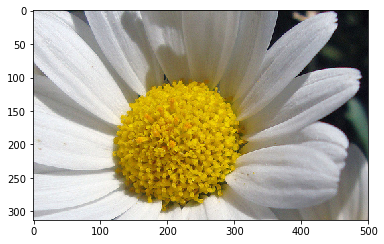

In [14]:
plt.imshow(Image.open('flower_photos/daisy/10140303196_b88d3d6cec.jpg'))

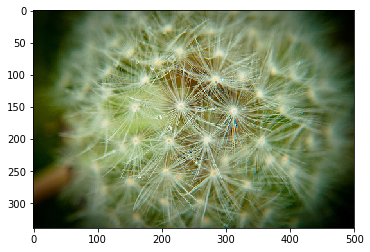

In [15]:
plt.imshow(Image.open('flower_photos/dandelion/10437652486_aa86c14985.jpg'))

## Read Labels

In [16]:
def flowers():
    classes = {}
    file_name_set = set()
    file_name_class = {}

    image_path = 'flower_photos'
    for dir_name in os.listdir(image_path):
        if os.path.isdir(image_path + '/' + dir_name):
            print(dir_name)
            classes.setdefault(dir_name, float(len(classes) + 1))
            for file_name in os.listdir(image_path + '/' + dir_name):
                if file_name in file_name_set:
                    print('Duplicate file name', file_name)
                file_name_set.add(file_name)
                file_name_class[file_name] = classes[dir_name]
            
    return classes, file_name_class

classes, train_image_to_class = flowers()

roses
daisy
tulips
Duplicate file name 15922772266_1167a06620.jpg
sunflowers
dandelion


In [17]:
classes

{'daisy': 2.0,
 'dandelion': 5.0,
 'roses': 1.0,
 'sunflowers': 4.0,
 'tulips': 3.0}

## Read files

To consume less memory and shorted training, we'll only use a random subsample.

In [18]:
classes.keys()

dict_keys(['roses', 'tulips', 'sunflowers', 'dandelion', 'daisy'])

In [47]:
!rm -rf sampled/

import os, shutil, subprocess

for class_name in classes.keys():
    sampled_train = 'sampled/train/'
    sampled_test = 'sampled/test/'
    if not os.path.exists(sampled_train + class_name):
        os.makedirs(sampled_train + class_name)
    if not os.path.exists(sampled_test + class_name):
        os.makedirs(sampled_test + class_name)

    subprocess.call(["cp flower_photos/" + class_name + "/[56]*.jpg " 
                     + sampled_train + class_name], shell=True)
    subprocess.call(["cp flower_photos/" + class_name + "/[7]*.jpg " 
                     + sampled_test + class_name], shell=True)

In [48]:
!ls -1 sampled/train/roses | wc -l
!ls -1 sampled/train/daisy | wc -l
!ls -1 sampled/train/sunflowers | wc -l
!ls -1 sampled/train/dandelion | wc -l
!ls -1 sampled/train/tulips | wc -l

!ls -1 sampled/test/roses | wc -l
!ls -1 sampled/test/daisy | wc -l
!ls -1 sampled/test/sunflowers | wc -l
!ls -1 sampled/test/dandelion | wc -l
!ls -1 sampled/test/tulips | wc -l

111
106
120
116
101
23
32
27
61
49


In [21]:
trainingDF = NNImageReader.readImages('sampled/train/*/*', sc).repartition(32).cache()
print ("partition number: ", trainingDF.rdd.getNumPartitions())
print ("image number: ", trainingDF.count())

partition number:  32
image number:  554


In [22]:
# os.listdir(data_path + '/train_img')

In [23]:
trainingDF

DataFrame[image: struct<origin:string,height:int,width:int,nChannels:int,mode:int,data:binary>]

In [24]:
trainingDF.show(10)

+--------------------+
|               image|
+--------------------+
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
|[file:/home/jovya...|
+--------------------+
only showing top 10 rows



#### Create array of labels

In [25]:
getName = udf(lambda row: row[0].split('/')[-1])
getLabel = udf(lambda name: train_image_to_class[name], DoubleType())
trainingDF = trainingDF \
    .withColumn("name", getName(col("image"))) \
    .withColumn("label", getLabel(col('name'))).cache()

In [26]:
trainingDF.rdd.getNumPartitions()

32

In [27]:
trainingDF.show(10)

+--------------------+--------------------+-----+
|               image|                name|label|
+--------------------+--------------------+-----+
|[file:/home/jovya...|5430796647_f21b7b...|  3.0|
|[file:/home/jovya...|5757012454_c37f30...|  5.0|
|[file:/home/jovya...|5955475577_3d9238...|  4.0|
|[file:/home/jovya...|5020805619_6c7107...|  4.0|
|[file:/home/jovya...|6998661030_46cbb7...|  3.0|
|[file:/home/jovya...|5088766459_f81f50...|  1.0|
|[file:/home/jovya...|5923649444_a823e5...|  4.0|
|[file:/home/jovya...|5665834973_76bd6c...|  2.0|
|[file:/home/jovya...|6958343928_7e596d...|  3.0|
|[file:/home/jovya...|5459481183_18d2d4...|  2.0|
+--------------------+--------------------+-----+
only showing top 10 rows



In [28]:
# (trainingDF, validationDF) = labelDF.randomSplit([0.9, 0.1])

In [29]:
trainingDF.count()

554

In [30]:
# validationDF.count()

Compose a pipeline

In [31]:
transformer = ChainedPreprocessing(
        [RowToImageFeature(), 
         ImageResize(256, 256), 
         ImageCenterCrop(224, 224),
         ImageChannelNormalize(123.0, 117.0, 104.0), 
         ImageMatToTensor(), 
         ImageFeatureToTensor()])

creating: createRowToImageFeature
creating: createImageResize
creating: createImageCenterCrop
creating: createImageChannelNormalize
creating: createImageMatToTensor
creating: createImageFeatureToTensor
creating: createChainedPreprocessing


Load pretrained model:

In [32]:
for layer in full_model.layers:
    print (layer.name())

data
conv1/7x7_s2
conv1/relu_7x7
pool1/3x3_s2
pool1/norm1
conv2/3x3_reduce
conv2/relu_3x3_reduce
conv2/3x3
conv2/relu_3x3
conv2/norm2
pool2/3x3_s2
inception_3a/3x3_reduce
inception_3a/5x5_reduce
inception_3a/relu_3x3_reduce
inception_3a/relu_5x5_reduce
inception_3a/pool
inception_3a/1x1
inception_3a/3x3
inception_3a/5x5
inception_3a/pool_proj
inception_3a/relu_pool_proj
inception_3a/relu_5x5
inception_3a/relu_3x3
inception_3a/relu_1x1
inception_3a/output
inception_3b/3x3_reduce
inception_3b/5x5_reduce
inception_3b/relu_3x3_reduce
inception_3b/relu_5x5_reduce
inception_3b/pool
inception_3b/1x1
inception_3b/3x3
inception_3b/5x5
inception_3b/pool_proj
inception_3b/relu_pool_proj
inception_3b/relu_5x5
inception_3b/relu_3x3
inception_3b/relu_1x1
inception_3b/output
pool3/3x3_s2
inception_4a/3x3_reduce
inception_4a/5x5_reduce
inception_4a/relu_3x3_reduce
inception_4a/relu_5x5_reduce
inception_4a/pool
inception_4a/1x1
inception_4a/3x3
inception_4a/5x5
inception_4a/pool_proj
inception_4a/relu_

In [33]:
model = full_model.new_graph(["pool5/drop_7x7_s1"])

In [34]:
for layer in model.layers:
    print(layer)

Input[data]
SpatialConvolution[conv1/7x7_s2](3 -> 64, 7 x 7, 2, 2, 3, 3)
ReLU[conv1/relu_7x7](0.0, 0.0)
SpatialMaxPooling[pool1/3x3_s2](3, 3, 2, 2, 0, 0)
SpatialCrossMapLRN[pool1/norm1](5, 9.999999747378752E-5, 0.75, 1.0)
SpatialConvolution[conv2/3x3_reduce](64 -> 64, 1 x 1, 1, 1, 0, 0)
ReLU[conv2/relu_3x3_reduce](0.0, 0.0)
SpatialConvolution[conv2/3x3](64 -> 192, 3 x 3, 1, 1, 1, 1)
ReLU[conv2/relu_3x3](0.0, 0.0)
SpatialCrossMapLRN[conv2/norm2](5, 9.999999747378752E-5, 0.75, 1.0)
SpatialMaxPooling[pool2/3x3_s2](3, 3, 2, 2, 0, 0)
SpatialConvolution[inception_3a/3x3_reduce](192 -> 96, 1 x 1, 1, 1, 0, 0)
SpatialConvolution[inception_3a/5x5_reduce](192 -> 16, 1 x 1, 1, 1, 0, 0)
ReLU[inception_3a/relu_3x3_reduce](0.0, 0.0)
ReLU[inception_3a/relu_5x5_reduce](0.0, 0.0)
SpatialMaxPooling[inception_3a/pool](3, 3, 1, 1, 1, 1)
SpatialConvolution[inception_3a/1x1](192 -> 64, 1 x 1, 1, 1, 0, 0)
SpatialConvolution[inception_3a/3x3](96 -> 128, 3 x 3, 1, 1, 1, 1)
SpatialConvolution[inception_3a/5x5](1

In [35]:
inputNode = Input(name="input", shape=(3, 224, 224))

creating: createZooKerasInput


In [36]:
EPOCHS = 5
LEARNING_RATE = 0.001
BATCH_SIZE = 16

In [37]:
inception = model.to_keras()(inputNode)
flatten = Flatten()(inception)
logits = Dense(len(classes))(flatten)
lrModel = Model(inputNode, logits)
classifier = NNClassifier(lrModel, CrossEntropyCriterion(), transformer) \
    .setLearningRate(LEARNING_RATE) \
    .setBatchSize(BATCH_SIZE) \
    .setMaxEpoch(EPOCHS) \
    .setFeaturesCol("image") \
    .setCachingSample(False)
pipeline = Pipeline(stages=[classifier])

creating: createZooKerasFlatten
creating: createZooKerasDense
creating: createZooKerasModel
creating: createCrossEntropyCriterion
creating: createScalarToTensor
creating: createFeatureLabelPreprocessing
creating: createNNClassifier


### Validation Set

In [49]:
validationDF = NNImageReader.readImages('sampled/test/*/*', sc).repartition(32).cache()
print ("partition number: ", validationDF.rdd.getNumPartitions())
print ("image number: ", validationDF.count())

partition number:  32
image number:  192


In [50]:
validationDF = validationDF \
    .withColumn("name", getName(col("image"))) \
    .withColumn("label", getLabel(col('name')))

### Set up Tensorboard for monitoring

In [89]:
!mkdir -p ~/work/tensorboard-logs/05-03-tensorboard/

# tensorboard_dir=os.environ.get('TENSORBOARD_DIR', '/tmp/tensorboard-logs')
tensorboard_dir = '/work/tensorboard-logs'
print("TENSORBOARD_DIR : ", tensorboard_dir)

app_name='05-03-tensorboard' #+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
base_path = os.path.abspath(os.path.join(tensorboard_dir, app_name))

# clean old logs
try:
    print ("Cleaning : ", base_path)
    shutil.rmtree(base_path)
except OSError as e:
    print (e)
    pass

mkdir: cannot create directory ‘/home/jovyan/work/tensorboard-logs/05-03-tensorboard/’: Permission denied
TENSORBOARD_DIR :  /work/tensorboard-logs
Cleaning :  /work/tensorboard-logs/05-03-tensorboard
[Errno 2] No such file or directory: '/work/tensorboard-logs/05-03-tensorboard'


In [76]:
from bigdl.optim.optimizer import EveryEpoch, Top1Accuracy, \
    TrainSummary, SeveralIteration, ValidationSummary

classifier.setValidation(EveryEpoch(), \
                        validationDF, \
                        [Top1Accuracy()], \
                        BATCH_SIZE)


train_summary = TrainSummary(log_dir=tensorboard_dir, app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir=tensorboard_dir, app_name=app_name)

log_path = os.path.abspath(os.path.join(tensorboard_dir, app_name))
print("saving logs to ",log_path)

classifier.setTrainSummary(train_summary)
classifier.setValidationSummary(val_summary)

creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary


Py4JJavaError: An error occurred while calling o42.createTrainSummary.
: java.io.FileNotFoundException: /home/jovyan/work/tensorboard-logs/05-03-tensorboard/train/bigdl.tfevents.1540620623.606057f5d5b6 (No such file or directory)
	at java.io.FileOutputStream.open0(Native Method)
	at java.io.FileOutputStream.open(FileOutputStream.java:270)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:213)
	at java.io.FileOutputStream.<init>(FileOutputStream.java:162)
	at com.intel.analytics.bigdl.visualization.tensorboard.RecordWriter.<init>(RecordWriter.scala:38)
	at com.intel.analytics.bigdl.visualization.tensorboard.EventWriter.<init>(EventWriter.scala:38)
	at com.intel.analytics.bigdl.visualization.tensorboard.FileWriter.<init>(FileWriter.scala:39)
	at com.intel.analytics.bigdl.visualization.TrainSummary.<init>(TrainSummary.scala:36)
	at com.intel.analytics.bigdl.python.api.PythonBigDL.createTrainSummary(PythonBigDL.scala:2348)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)


In [38]:
flower_model = pipeline.fit(trainingDF)

creating: createToTuple
creating: createChainedPreprocessing


In [39]:
trainingDF.drop()
trainingDF = None

## Predict Flowers

In [51]:
predDF = flower_model.transform(validationDF).cache()

In [52]:
predDF.show(20)

+--------------------+--------------------+-----+----------+
|               image|                name|label|prediction|
+--------------------+--------------------+-----+----------+
|[file:/home/jovya...|7669550908_bc5a11...|  2.0|       2.0|
|[file:/home/jovya...|7791014076_07a897...|  4.0|       4.0|
|[file:/home/jovya...|7082608511_f4cf23...|  3.0|       4.0|
|[file:/home/jovya...|7247182064_f8d675...|  3.0|       3.0|
|[file:/home/jovya...|7166570828_7c26ca...|  3.0|       1.0|
|[file:/home/jovya...|779359602_30abcbf...|  3.0|       3.0|
|[file:/home/jovya...|7177682195_c29265...|  3.0|       3.0|
|[file:/home/jovya...|7094415739_6b29e5...|  3.0|       1.0|
|[file:/home/jovya...|7376471712_e1be79...|  1.0|       1.0|
|[file:/home/jovya...|7719263062_3c8a30...|  5.0|       2.0|
|[file:/home/jovya...|7280217714_fb9ffc...|  5.0|       5.0|
|[file:/home/jovya...|7012364067_5ffc76...|  4.0|       4.0|
|[file:/home/jovya...|7409458444_0bfc9a...|  1.0|       1.0|
|[file:/home/jovya...|76

### Calculate accuracy

In [53]:
results = predDF.select("name", "label", "prediction")

In [54]:
# predDF.unpersist()
# predDF.drop()

In [55]:
correct = results.filter("label = prediction").count()

In [56]:
total = predDF.count()
accuracy = correct * 1.0 / total
print(accuracy)

0.7604166666666666


In [57]:
predDF.show()

+--------------------+--------------------+-----+----------+
|               image|                name|label|prediction|
+--------------------+--------------------+-----+----------+
|[file:/home/jovya...|7669550908_bc5a11...|  2.0|       2.0|
|[file:/home/jovya...|7791014076_07a897...|  4.0|       4.0|
|[file:/home/jovya...|7082608511_f4cf23...|  3.0|       4.0|
|[file:/home/jovya...|7247182064_f8d675...|  3.0|       3.0|
|[file:/home/jovya...|7166570828_7c26ca...|  3.0|       1.0|
|[file:/home/jovya...|779359602_30abcbf...|  3.0|       3.0|
|[file:/home/jovya...|7177682195_c29265...|  3.0|       3.0|
|[file:/home/jovya...|7094415739_6b29e5...|  3.0|       1.0|
|[file:/home/jovya...|7376471712_e1be79...|  1.0|       1.0|
|[file:/home/jovya...|7719263062_3c8a30...|  5.0|       2.0|
|[file:/home/jovya...|7280217714_fb9ffc...|  5.0|       5.0|
|[file:/home/jovya...|7012364067_5ffc76...|  4.0|       4.0|
|[file:/home/jovya...|7409458444_0bfc9a...|  1.0|       1.0|
|[file:/home/jovya...|76

In [63]:
a = udf(lambda a, b: 1 if a == b else 0)
results = results.withColumn("correct", a(col('label'), col('prediction')))

In [64]:
results.show()

+--------------------+-----+----------+-------+
|                name|label|prediction|correct|
+--------------------+-----+----------+-------+
|7669550908_bc5a11...|  2.0|       2.0|      1|
|7791014076_07a897...|  4.0|       4.0|      1|
|7082608511_f4cf23...|  3.0|       4.0|      0|
|7247182064_f8d675...|  3.0|       3.0|      1|
|7166570828_7c26ca...|  3.0|       1.0|      0|
|779359602_30abcbf...|  3.0|       3.0|      1|
|7177682195_c29265...|  3.0|       3.0|      1|
|7094415739_6b29e5...|  3.0|       1.0|      0|
|7376471712_e1be79...|  1.0|       1.0|      1|
|7719263062_3c8a30...|  5.0|       2.0|      0|
|7280217714_fb9ffc...|  5.0|       5.0|      1|
|7012364067_5ffc76...|  4.0|       4.0|      1|
|7409458444_0bfc9a...|  1.0|       1.0|      1|
|7630517248_98fb8b...|  2.0|       2.0|      1|
|7808430998_31ba63...|  5.0|       5.0|      1|
|7186509956_c37c02...|  1.0|       1.0|      1|
|7042692841_f32379...|  3.0|       3.0|      1|
|7447655334_e8f805...|  3.0|       3.0| 

In [69]:
from pyspark.sql.functions import count, avg, sum

results.groupBy('label') \
    .agg(sum('correct'), count('correct'), sum('correct') / count('correct')) \
    .show()

+-----+------------+--------------+-------------------------------+
|label|sum(correct)|count(correct)|(sum(correct) / count(correct))|
+-----+------------+--------------+-------------------------------+
|  1.0|        16.0|            23|             0.6956521739130435|
|  4.0|        19.0|            27|             0.7037037037037037|
|  3.0|        32.0|            49|             0.6530612244897959|
|  2.0|        26.0|            32|                         0.8125|
|  5.0|        53.0|            61|             0.8688524590163934|
+-----+------------+--------------+-------------------------------+



In [70]:
classes

{'daisy': 2.0,
 'dandelion': 5.0,
 'roses': 1.0,
 'sunflowers': 4.0,
 'tulips': 3.0}